# Total Market Cap to GDP Ratio

This notebook is looking at the total US market cap (via Wilshire 5000 index) to US GDP ratio.

In part this is an exercise in accessing and manipulating financial data using Python.

In [76]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import requests_cache
from plotnine import ggplot, geom_point, aes, geom_boxplot, scale_x_discrete, themes

In [2]:
# We don't need to continually refresh this data, so leveraging the built-in caching capabilities.

expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)

In [61]:
def fetch_tmc_gdp_df(start: datetime = None, end: datetime = None) -> pd.DataFrame:
    """
    Fetches data from FRED.
    
    Parameters:
    start (datetime): Start of date range for pulling data.
    end (datetime): End of date range for pulling data.
    
    Returns:
    A Pandas dataframe with total market cap, gdp, ratio, date stamp, and month stamp.
    """
    
    if start is None:
        start = datetime.datetime(2000,1,1)
    if end is None:
        end = datetime.datetime.now()
        
    tmc = web.DataReader('WILL5000PRFC', 'fred', start, end, session=session)
    
    tmc.loc[datetime.datetime(2020,3,26), 'WILL5000PRFC'] = 26014.11
    
    gdp = web.DataReader('GDP', 'fred', start, end, session=session)

    df = pd.merge(tmc, gdp, on='DATE', how='left').reset_index()
    df = df.fillna(method='pad')
    df['RATIO'] = df['WILL5000PRFC'] * 100 / df['GDP']
    df = df.dropna()
    df['MONTH'] = [str(x)[:7] for x in df['DATE']]
    
    return df
    

In [63]:
my_ratio_df = fetch_tmc_gdp_df()

Example data from the end of the data frame.

In [71]:
my_ratio_df.tail()

,DATE,WILL5000PRFC,GDP,RATIO,MONTH
5299,2020-04-24,28483.89,21537.94,132.249834,2020-04
5300,2020-04-27,28990.17,21537.94,134.600477,2020-04
5301,2020-04-28,28876.23,21537.94,134.071457,2020-04
5302,2020-04-29,29719.03,21537.94,137.984552,2020-04
5303,2020-04-30,29365.43,21537.94,136.342798,2020-04


Summary statistics for the tmc/gdp ratio.

In [86]:
my_ratio_df[['RATIO']].describe(percentiles=[.1, .25, .5, .75, .9])

,RATIO
count,5044.000000
mean,102.688465
std,21.942508
min,47.646029
10%,76.824568
25%,88.214582
50%,98.405082
75%,117.862819
90%,137.077975
max,160.340079


Plotting the tmc/gdp ratio starting in 2010, near the end of the GFC.

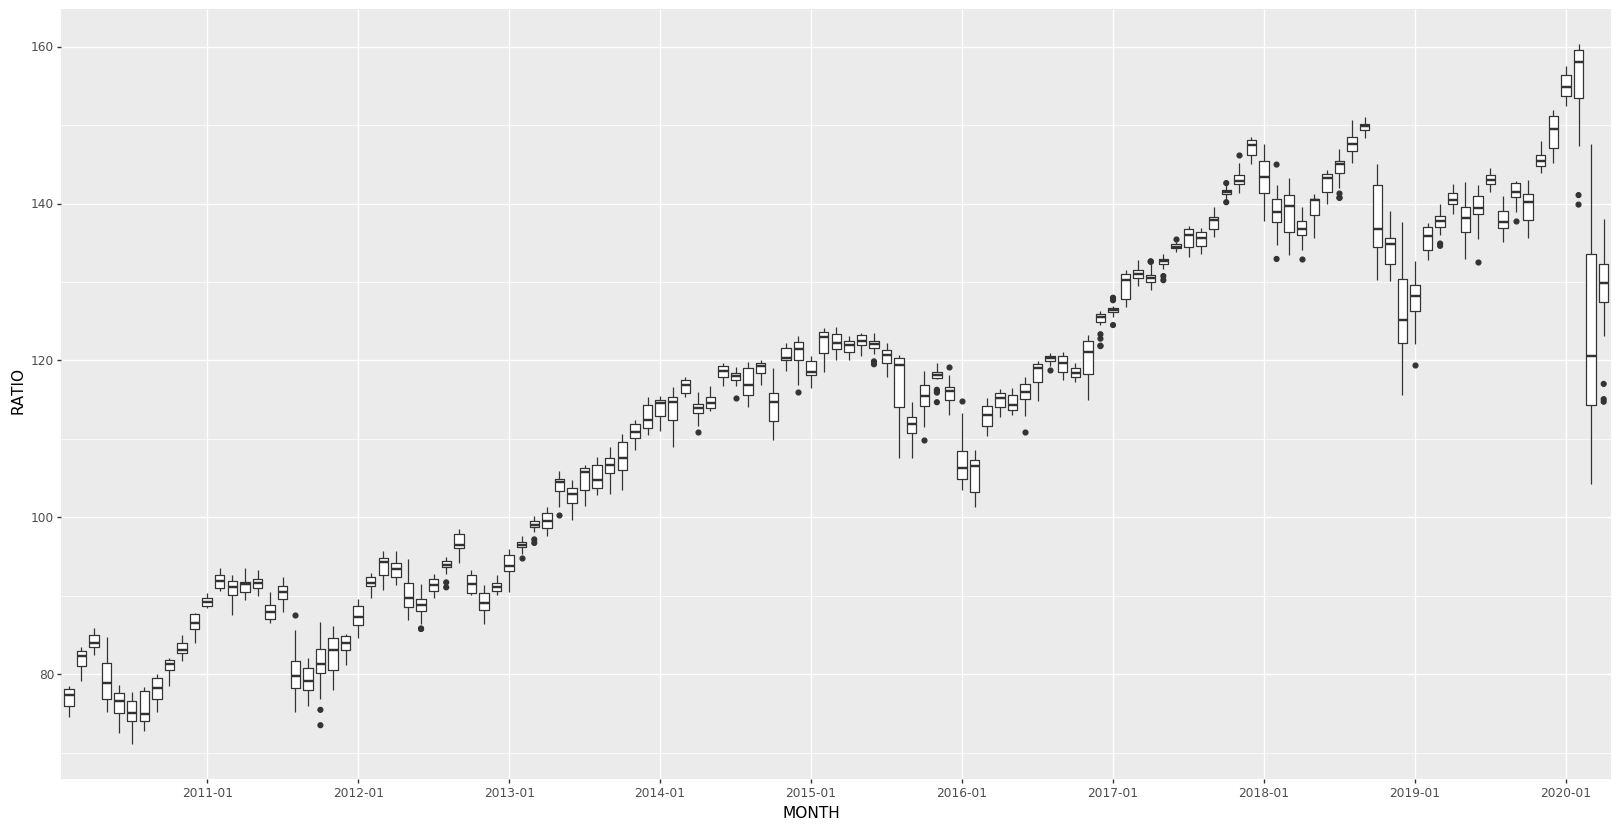

<ggplot: (312288142)>


In [85]:
print(ggplot(my_ratio_df.loc[my_ratio_df['MONTH'] > '2010-01'])
     + geom_boxplot(aes(x='factor(MONTH)', y='RATIO'))
     + scale_x_discrete(name='MONTH', breaks=lambda arr: [x for x in arr if x[5:7] == '01'])
     + themes.theme_gray()
     + themes.theme(figure_size=(20,10)))